<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/Meteorology_replace-missing-values/blob/master/Replace_Missing_Values_Temperature%5BBoaVista%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://raw.githubusercontent.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/master/DadosDiarios/boavistdiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,23814.0,23814.000000,11696.000000,11290.000000,11618.000000,9491.000000,9882.000000,11147.000000,9331.000000,12006.000000,0.0
mean,82024.0,590.073066,4.653967,33.421940,24.026743,5.317997,4.679903,27.988791,76.149207,1.609315,NaN
std,0.0,599.930471,11.862902,2.181742,1.226798,3.287892,3.007448,1.501311,10.587840,1.199299,NaN
min,82024.0,0.000000,0.000000,20.800000,12.400000,0.000000,0.000000,20.800000,34.000000,0.000000,NaN
25%,82024.0,0.000000,0.000000,32.200000,23.200000,2.400000,2.400000,26.980000,68.000000,0.666667,NaN
50%,82024.0,0.000000,0.000000,33.600000,24.200000,5.500000,4.100000,28.120000,76.250000,1.543320,NaN
75%,82024.0,1200.000000,2.900000,35.000000,24.900000,8.200000,6.400000,29.100000,85.000000,2.333333,NaN
max,82024.0,1200.000000,149.400000,42.000000,29.800000,11.700000,32.000000,32.820000,100.000000,7.459380,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,82024,1980-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.566667,NaN
1,82024,1980-01-02,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.533333,NaN
2,82024,1980-01-03,0,NaN,31.4,NaN,1.8,6.5,26.12,89.25,3.766667,NaN
3,82024,1980-01-03,1200,0.0,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN
4,82024,1980-01-04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.600000,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,11290.000000,0.0,9491.000000,9882.000000,11147.000000,9331.000000,12006.000000
mean,NaN,33.421940,NaN,5.317997,4.679903,27.988791,76.149207,1.609315
std,NaN,2.181742,NaN,3.287892,3.007448,1.501311,10.587840,1.199299
min,NaN,20.800000,NaN,0.000000,0.000000,20.800000,34.000000,0.000000
25%,NaN,32.200000,NaN,2.400000,2.400000,26.980000,68.000000,0.666667
50%,NaN,33.600000,NaN,5.500000,4.100000,28.120000,76.250000,1.543320
75%,NaN,35.000000,NaN,8.200000,6.400000,29.100000,85.000000,2.333333
max,NaN,42.000000,NaN,11.700000,32.000000,32.820000,100.000000,7.459380


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,11696.000000,0.0,11618.000000,0.0,0.0,0.0,0.0,0.0
mean,4.653967,NaN,24.026743,NaN,NaN,NaN,NaN,NaN
std,11.862902,NaN,1.226798,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,12.400000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,23.200000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,24.200000,NaN,NaN,NaN,NaN,NaN
75%,2.900000,NaN,24.900000,NaN,NaN,NaN,NaN,NaN
max,149.400000,NaN,29.800000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,3.566667
1980-01-02,NaN,NaN,NaN,NaN,NaN,2.533333
1980-01-03,31.4,1.8,6.5,26.12,89.25,3.766667
1980-01-04,NaN,NaN,NaN,NaN,NaN,3.600000
1980-01-05,NaN,NaN,NaN,NaN,NaN,4.500000


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1980-01-03,0.0,23.0
1980-01-06,0.0,23.3
1980-01-09,0.0,21.5
1980-01-13,0.0,20.6
1980-01-14,0.0,22.2


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado da junção dos dataSet00 e dataSet12
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
#Mostrando o resultado da junção
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,3.566667,NaN,NaN
1980-01-02,NaN,NaN,NaN,NaN,NaN,2.533333,NaN,NaN
1980-01-03,31.4,1.8,6.5,26.12,89.25,3.766667,0.0,23.0
1980-01-04,NaN,NaN,NaN,NaN,NaN,3.600000,NaN,NaN
1980-01-05,NaN,NaN,NaN,NaN,NaN,4.500000,NaN,NaN


In [19]:
#Quantidade de dias existentes na base de dados
len(dataSetProv)

13880

In [0]:
#Tornando o dataSet como sendo o dataSet provisório
dataSet = dataSetProv

In [21]:
#Descrevendo o novo dataSet
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,11290.000000,9491.000000,9882.000000,11147.000000,9331.000000,12006.000000,11696.000000,11618.000000
mean,33.421940,5.317997,4.679903,27.988791,76.149207,1.609315,4.653967,24.026743
std,2.181742,3.287892,3.007448,1.501311,10.587840,1.199299,11.862902,1.226798
min,20.800000,0.000000,0.000000,20.800000,34.000000,0.000000,0.000000,12.400000
25%,32.200000,2.400000,2.400000,26.980000,68.000000,0.666667,0.000000,23.200000
50%,33.600000,5.500000,4.100000,28.120000,76.250000,1.543320,0.000000,24.200000
75%,35.000000,8.200000,6.400000,29.100000,85.000000,2.333333,2.900000,24.900000
max,42.000000,11.700000,32.000000,32.820000,100.000000,7.459380,149.400000,29.800000


In [22]:
#Mostrando o cabeçalho do novo dataSet
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,3.566667,NaN,NaN
1980-01-02,NaN,NaN,NaN,NaN,NaN,2.533333,NaN,NaN
1980-01-03,31.4,1.8,6.5,26.12,89.25,3.766667,0.0,23.0
1980-01-04,NaN,NaN,NaN,NaN,NaN,3.600000,NaN,NaN
1980-01-05,NaN,NaN,NaN,NaN,NaN,4.500000,NaN,NaN


# Modelagem para previsão de Temperatura Máxima

In [0]:
#Separando base de dados para treino de rede neural para previsão de temperatura máxima
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [25]:
#Visualizando cabeçalho dos dados para treino
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,
1980-01-03,1.8,6.5,26.12,89.25,3.766667,0.0,23.0
1980-01-06,5.3,9.3,27.40,76.50,3.800000,0.0,23.3
1980-01-09,2.9,9.1,26.72,79.00,3.033333,0.0,21.5
1980-01-13,11.0,9.2,26.96,68.00,3.466667,0.0,20.6
1980-01-14,11.0,10.2,28.24,70.50,4.100000,0.0,22.2


In [26]:
#Visualizando cabeçalho das informações de temperatura 
tempMax.head()

Data
1980-01-03    31.4
1980-01-06    32.6
1980-01-09    32.3
1980-01-13    33.0
1980-01-14    33.6
Name: TempMaxima, dtype: float64

In [0]:
#Guardando a informação de como as colunas estão distribuídas no dataFrame
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [29]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,9144.000000,9615.000000,11143.000000,8989.000000,11228.000000,11259.000000,11215.000000
mean,-0.095524,-0.709723,0.196083,0.282632,-0.557786,-0.936582,0.334817
std,0.563434,0.187179,0.249776,0.319430,0.326502,0.160148,0.140822
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.589744,-0.850000,0.028286,0.030303,-0.813953,-1.000000,0.241379
50%,-0.059829,-0.750000,0.217970,0.287879,-0.581395,-1.000000,0.344828
75%,0.401709,-0.606250,0.381032,0.545455,-0.348837,-0.959839,0.436782
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0 
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [31]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(11290, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 7, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [38]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 876.4937 - mean_absolute_error: 29.4446
Epoch 2/200
 - 1s - loss: 547.7371 - mean_absolute_error: 23.2504
Epoch 3/200
 - 1s - loss: 333.0697 - mean_absolute_error: 18.0652
Epoch 4/200
 - 1s - loss: 186.8652 - mean_absolute_error: 13.4398
Epoch 5/200
 - 1s - loss: 93.5205 - mean_absolute_error: 9.3557
Epoch 6/200
 - 1s - loss: 40.3669 - mean_absolute_error: 5.9347
Epoch 7/200
 - 1s - loss: 15.3632 - mean_absolute_error: 3.4304
Epoch 8/200
 - 1s - loss: 6.7390 - mean_absolute_error: 2.1445
Epoch 9/200
 - 1s - loss: 4.8969 - mean_absolute_error: 1.7615
Epoch 10/200
 - 1s - loss: 4.7124 - mean_absolute_error: 1.6996
Epoch 11/200
 - 1s - lo

In [39]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -1.176635, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-1.176635 (0.076640) {'batch_size': 10, 'camadas': 2, 'units': 7}


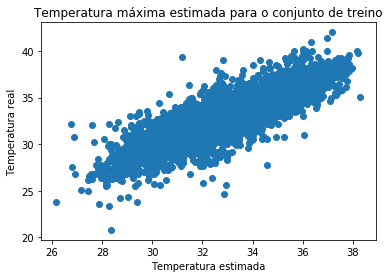

In [40]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [41]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.         0.87130288]
 [0.87130288 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

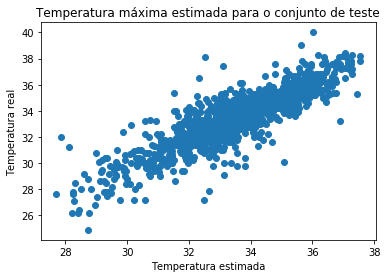

In [43]:
#Gráfico que mostra a relação entre a temperatura máxima real e a prevista para o conjunto de teste
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.         0.87007653]
 [0.87007653 1.        ]]


In [45]:
#Erro absoluto médio entre a temperatura máxima prevista e a real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

0.7942149737538016


In [46]:
#Erro quadrático médio entre a temperatura máxima prevista e a real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

1.1788651949646693


# Modelagem para previsão de Temperatura Mínima

In [0]:
#Separando dados para treinar rede neural para previsão de temperatura mínima
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [49]:
#Visualizando dados de treino para temperatura mínima
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
Data,,,,,,,
1980-01-03,31.4,1.8,6.5,26.12,89.25,3.766667,0.0
1980-01-06,32.6,5.3,9.3,27.40,76.50,3.800000,0.0
1980-01-09,32.3,2.9,9.1,26.72,79.00,3.033333,0.0
1980-01-13,33.0,11.0,9.2,26.96,68.00,3.466667,0.0
1980-01-14,33.6,11.0,10.2,28.24,70.50,4.100000,0.0


In [50]:
#Visualizando informações de temperatura mínima para cada um dos dados de treino 
tempMin.head()

Data
1980-01-03    23.0
1980-01-06    23.3
1980-01-09    21.5
1980-01-13    20.6
1980-01-14    22.2
Name: TempMinima, dtype: float64

In [0]:
#Guardando informação de como as colunas estão distribuídas no dataFrame 
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [53]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
count,11215.000000,9434.000000,9796.000000,11126.000000,9264.000000,11554.000000,11604.000000
mean,0.190461,-0.092084,-0.706889,0.140182,0.277158,-0.566544,-0.937724
std,0.205692,0.561912,0.188180,0.265080,0.320943,0.318371,0.158823
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.075472,-0.589744,-0.850000,-0.037433,0.030303,-0.821254,-1.000000
50%,0.207547,-0.059829,-0.743750,0.162210,0.280303,-0.579947,-1.000000
75%,0.339623,0.401709,-0.600000,0.336898,0.545455,-0.374390,-0.961178
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [55]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(11618, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [61]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Epoch 1/200
 - 1s - loss: 407.7721 - mean_absolute_error: 20.0353
Epoch 2/200
 - 1s - loss: 198.6489 - mean_absolute_error: 13.9588
Epoch 3/200
 - 1s - loss: 87.9802 - mean_absolute_error: 9.2193
Epoch 4/200
 - 1s - loss: 31.8039 - mean_absolute_error: 5.4293
Epoch 5/200
 - 1s - loss: 8.9276 - mean_absolute_error: 2.7034
Epoch 6/200
 - 1s - loss: 2.5342 - mean_absolute_error: 1.3214
Epoch 7/200
 - 1s - loss: 1.5550 - mean_absolute_error: 0.9872
Epoch 8/200
 - 1s - loss: 1.4950 - mean_absolute_error: 0.9500
Epoch 9/200
 - 1s - loss: 1.4941 - mean_absolute_error: 0.9482
Epoch 10/200
 - 1s - loss: 1.4949 - mean_absolute_error: 0.9474
Epoch 11/200
 - 1s - loss: 1.4946 - mean_absolute_error: 0.9476
Epoch 12/200
 - 1s - loss: 1.4947 - mean_absolute_error: 0.9478
Epoch 13/200
 - 1s - l

In [62]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.745730, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.745730 (0.025626) {'batch_size': 10, 'camadas': 2, 'units': 7}


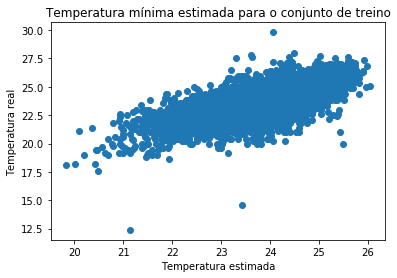

In [63]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [64]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.72674494]
 [0.72674494 1.        ]]


In [0]:
#Previsão para os dados de teste a partir da modelagem obtida
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

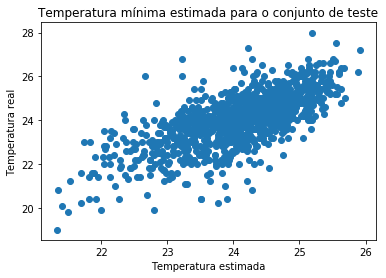

In [66]:
#Gráfico que mostra a relação entre a temperatura mínima real e a temperatura mínima prevista para os dados de teste
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.         0.70695872]
 [0.70695872 1.        ]]


In [68]:
#Erro absoluto médio entre temperatura mínima real e prevista para os dados de teste
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.6446293320384985


In [69]:
#Erro quadrático médio entre a temperatura mínima real e a prevista para os dados de teste
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

0.7229420048440769


In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pickle
# Salvando os modelos treinados
filename = '/content/gdrive/My Drive/TemperaturaMaximaBoaVista.sav'
pickle.dump(grid_searchTempMax, open(filename, 'wb'))

In [0]:
filename = '/content/gdrive/My Drive/TemperaturaMinimaBoaVista.sav'
pickle.dump(grid_searchTempMin, open(filename, 'wb'))